In [4]:
import numpy as np
from time import sleep

In [5]:
import tables

In [6]:
import pandas as pd

In [7]:
from scipy.interpolate import interp1d

In [8]:
from astropy.cosmology import FlatLambdaCDM, Planck18

In [9]:
import vrpy_tools

In [10]:
import matplotlib.pyplot as plt

In [11]:
L=150
i=100
rund='r1'

In [12]:
siminfo = vrpy_tools.ReadSimInfo(f"/scratch/cprem/sims/bdm_cdm1024/{rund:s}/halos_vr_6d/out_{i:03d}")

In [13]:
config = vrpy_tools.ReadConfigInfo(f"/scratch/cprem/sims/bdm_cdm1024/{rund:s}/halos_vr_6d/out_{i:03d}")

In [14]:
# config

In [15]:
a = siminfo['ScaleFactor']
z = 1/a - 1
h = siminfo['h_val']
Om_m = siminfo['Omega_m']

In [16]:
p18py = Planck18

In [17]:
a

0.538462

In [18]:
vir_dens = config['Virial_density']*config['Critical_density']/p18py.Om(z)/ (h**2/a**3)

In [19]:
# vir_dens *= h**2 / a**3; vir_dens

In [20]:
vir_dens/config['Virial_density']

114940070706.74513

In [21]:
# siminfo

In [22]:
halprop = tables.open_file(f"/scratch/cprem/sims/bdm_cdm1024/{rund:s}/halos_vr_6d/out_{i:03d}.properties.0", 'r')

In [23]:
halprop.root.Mass_200mean

/Mass_200mean (Array(1484193,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None

In [24]:
halprop.root.hostHaloID

/hostHaloID (Array(1484193,)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None

In [25]:
kin_ratio = 2*halprop.root.Ekin[:] /np.abs(halprop.root.Epot[:]); print(kin_ratio<1.5)

[ True False  True ...  True  True False]


In [26]:
radprof = tables.open_file(f"/scratch/cprem/sims/bdm_cdm1024/{rund:s}/halos_vr_6d/out_{i:03d}.profiles.0", 'r')

In [27]:
radprof.root.Mass_profile

/Mass_profile (Array(1484193, 20)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None

In [28]:
# select_mass_ind = np.where(np.logical_and(halvirmass>5e1, halvirmass<6e1))

In [29]:
massbins = 10**np.arange(1,4.1,0.5)*1e10
halvirmass = halprop.root.Mass_BN98[:]

In [30]:
radbins = np.logspace(-1.3,-0.3,10)
halvirrad = halprop.root.R_BN98[:]

In [31]:
# j=10

In [32]:
# np.where(np.logical_and(halvirmass>massbins[j], halvirmass<massbins[j+1], halprop.root.hostHaloID[:]==-1))

In [33]:
# radprof.root.Mass_profile[:,0][select_mass_ind[0]]

In [34]:
Rad_bin_edge = radprof.root.Radial_bin_edges[:]

In [35]:
Rad_bin_cen = (Rad_bin_edge[1:] + Rad_bin_edge[:-1])/ 2

In [36]:
Rad_bin_cen

array([0.005     , 0.01168617, 0.01562714, 0.02089714, 0.02794437,
       0.03736816, 0.04996996, 0.06682153, 0.08935601, 0.11948988,
       0.15978592, 0.21367114, 0.28572828, 0.38208555, 0.51093773,
       0.68324323, 0.91365599, 1.22177175, 1.63379455, 2.18476541])

100000000000.0 316227766016.83795 500
0.144990873547836


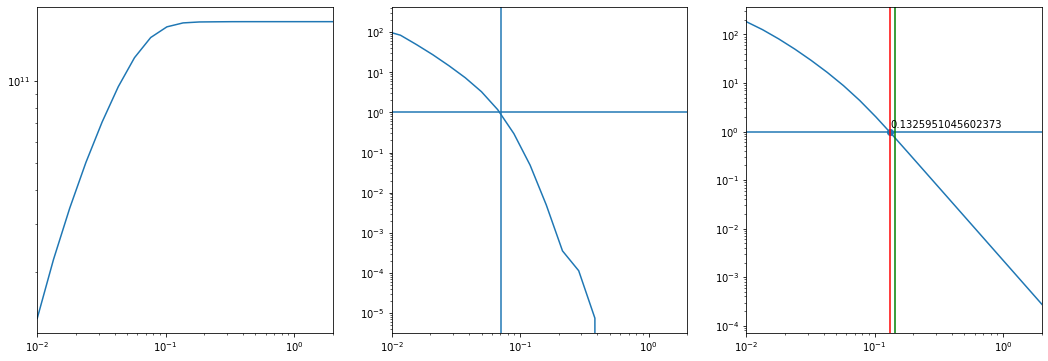

500
316227766016.83795 1000000000000.0 500
0.1960190578082998


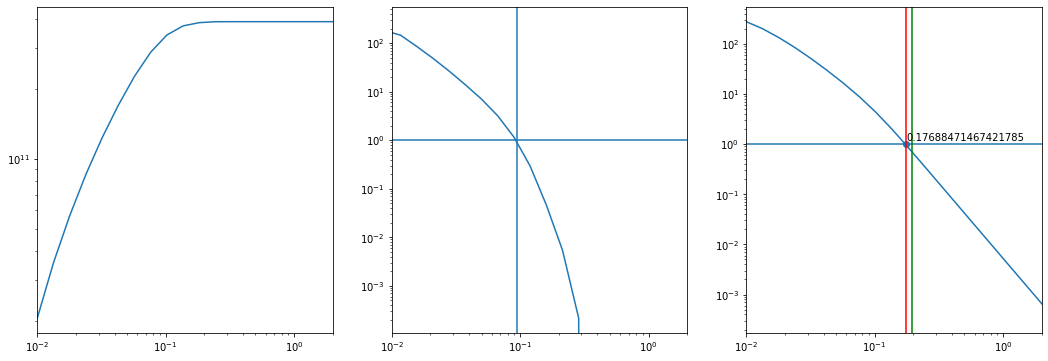

500
1000000000000.0 3162277660168.3794 500
0.2818197431473161


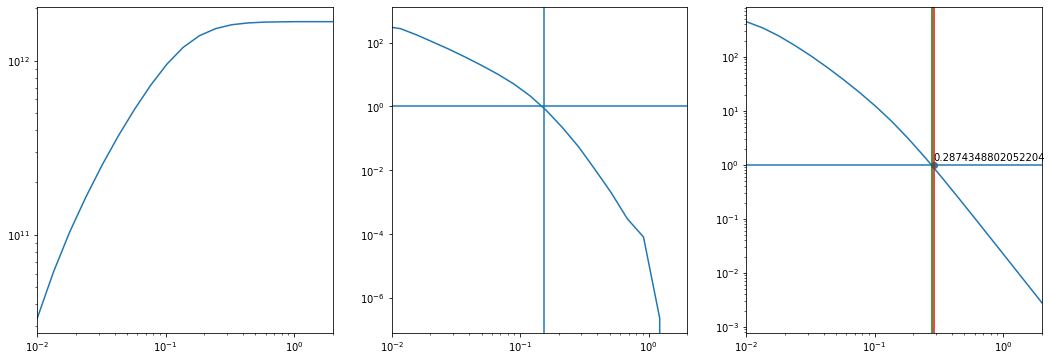

500
3162277660168.3794 10000000000000.0 500
0.40792950313065457
noisy data


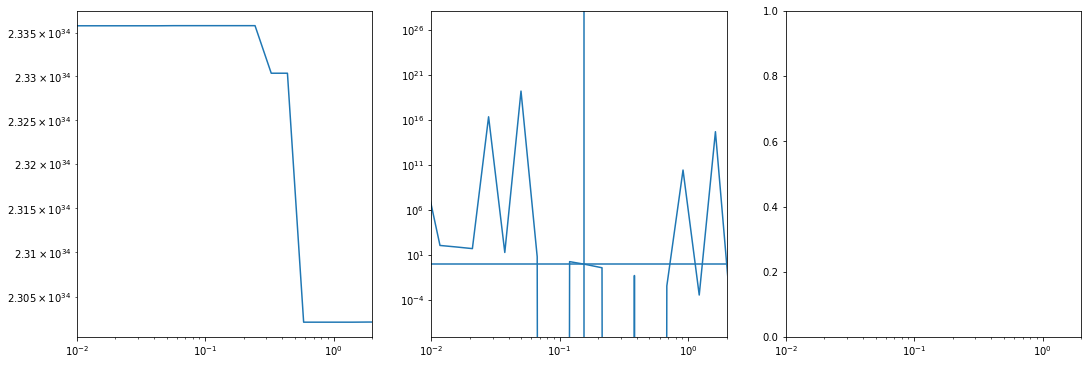

In [37]:
for j in range(len(massbins)-1):
    try:
        select_mass_ind = np.where(np.all((halvirmass>massbins[j], halvirmass<massbins[j+1], halprop.root.hostHaloID[:]==-1, abs(kin_ratio-1) < 0.5), axis=0))[0][:500]
        print(massbins[j], massbins[j+1], len(select_mass_ind))
        mass_profile_mean = radprof.root.Mass_profile[:][select_mass_ind].mean(axis=0)
        r_vir_vr_mean = halprop.root.R_BN98[:][select_mass_ind].mean(axis=0)
        print(r_vir_vr_mean)
        fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(18,6), sharex=True)
        ax1.loglog(Rad_bin_edge[1:], np.cumsum(mass_profile_mean))
        ax1.set_xlim(1e-2,2)
        rhor = mass_profile_mean/ (4/3*np.pi* (Rad_bin_edge[1:]**3-Rad_bin_edge[:-1]**3) )/ vir_dens
        r_rho_is_vir = interp1d(rhor, Rad_bin_cen)(1)
        ax2.loglog(Rad_bin_cen, rhor,)
        ax2.axhline(1)
        ax2.axvline(r_rho_is_vir)
        rhoR = np.cumsum(mass_profile_mean)/ (4/3*np.pi* (Rad_bin_edge[1:]**3))/ vir_dens
        r_vir = interp1d(rhoR, Rad_bin_edge[1:])(1)
    #     idx_vir = np.argwhere(np.diff(np.sign(rhoR-1))).flatten()
        ax3.loglog(Rad_bin_edge[1:], rhoR ,)
        ax3.axhline(1)
        ax3.axvline(r_vir,color='red')
        ax3.axvline(r_vir_vr_mean, color='green')
        ax3.scatter(r_vir,1)
        ax3.annotate(f'{r_vir}', (r_vir,1.2))
    #     plt.ylim(0, 3)
        plt.show()
        sleep(.01)
        plt.close()
        print(len(select_mass_ind))
    except:
        print('noisy data')
        break
# plt.plot(radprof.root.Radial_bin_edges[1:], radprof.root.Mass_profile[:][np.where(np.logical_and(halvirmass>9e2, halvirmass<12e2))].mean(axis=0))

0.05011872336272722 0.06473082037010398 245907
0.06022963614442859


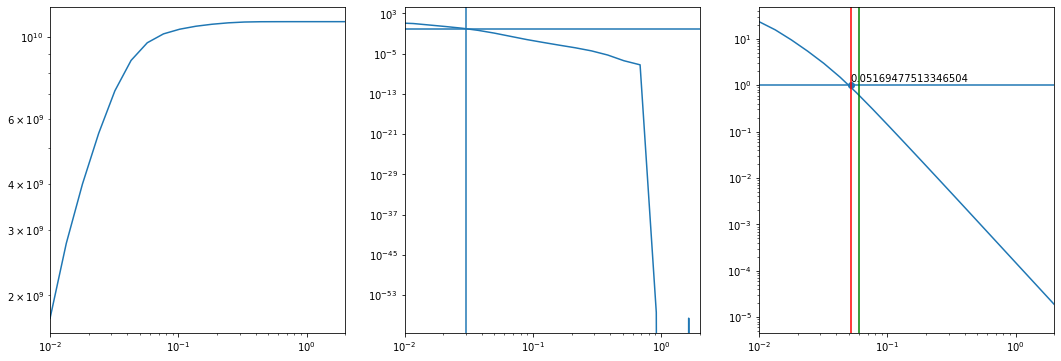

0.06473082037010398 0.08360306936514639 458282
0.07296232327337328


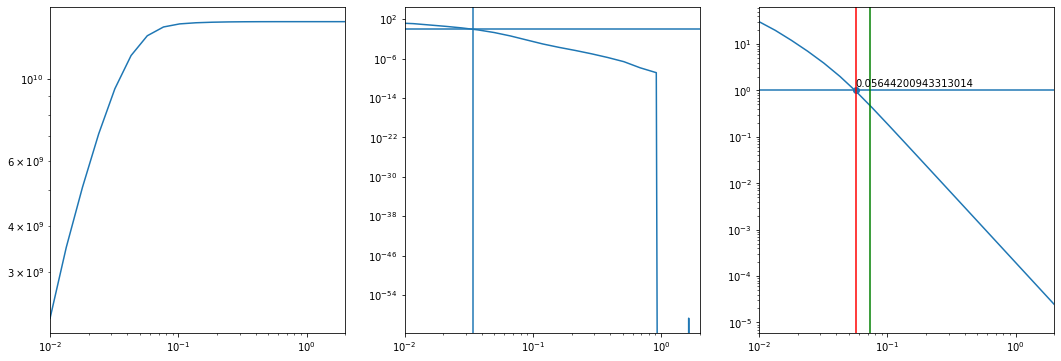

0.08360306936514639 0.10797751623277094 247719
0.09390030673070572


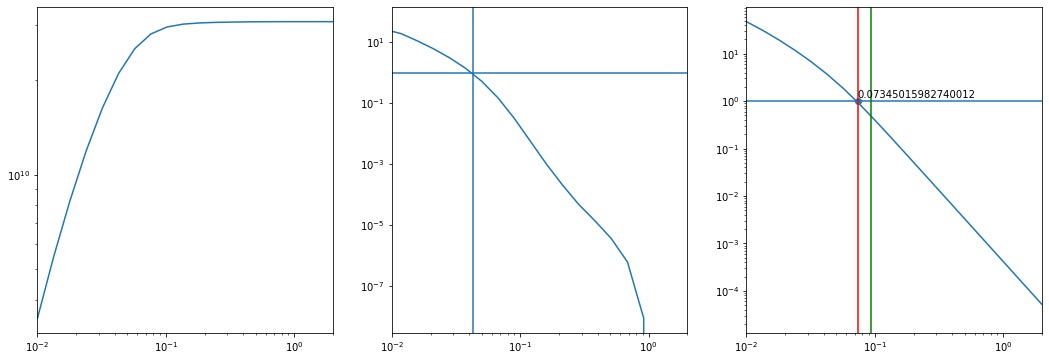

0.10797751623277094 0.1394583249195745 127307
0.12125947248836369


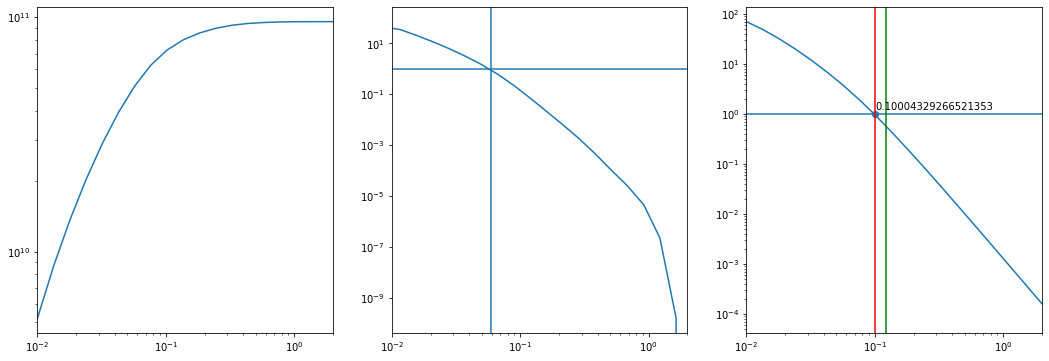

0.1394583249195745 0.1801173528334133 62198
0.15647636811670526


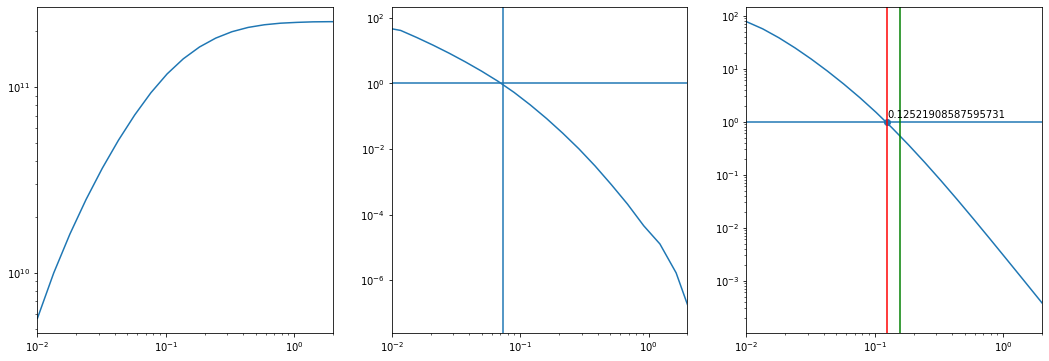

0.1801173528334133 0.23263050671536256 29321
0.20191986104301946


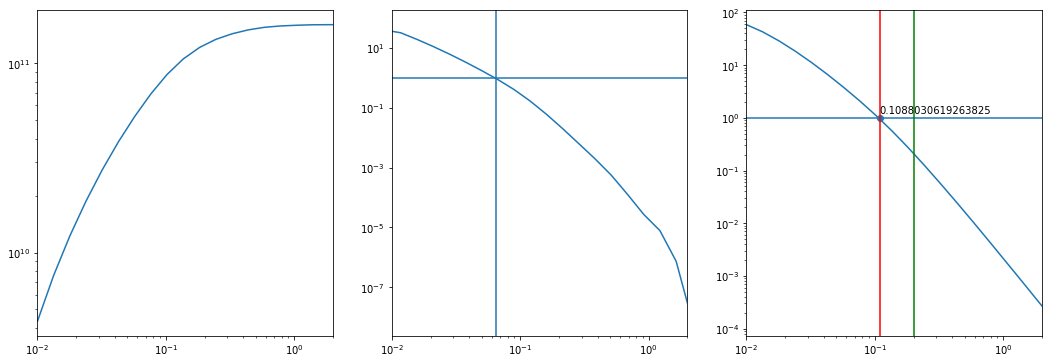

0.23263050671536256 0.3004538530204692 13486
0.2608481939729257


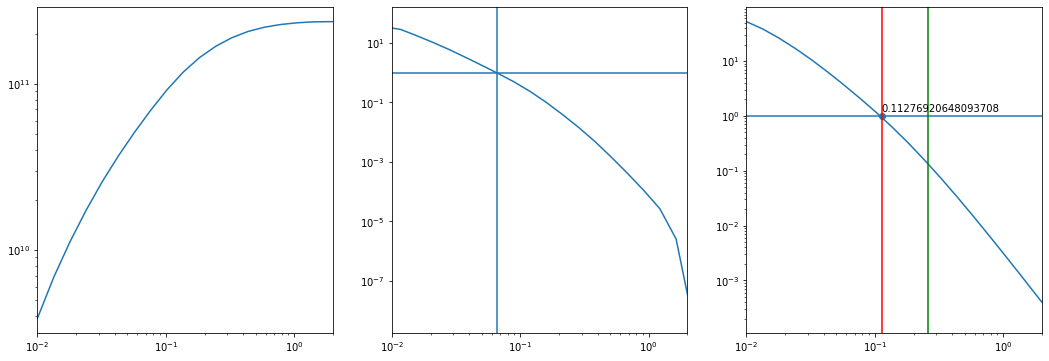

0.3004538530204692 0.3880510732210182 5857
0.33636365001529


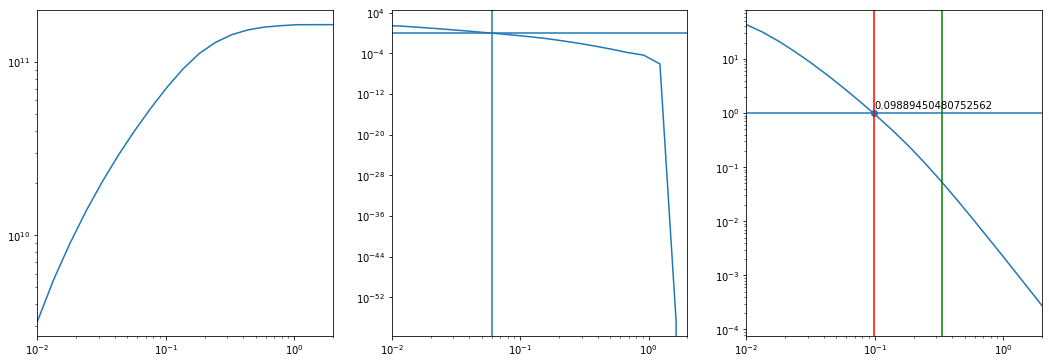

0.3880510732210182 0.5011872336272722 2372
0.4329404496670347


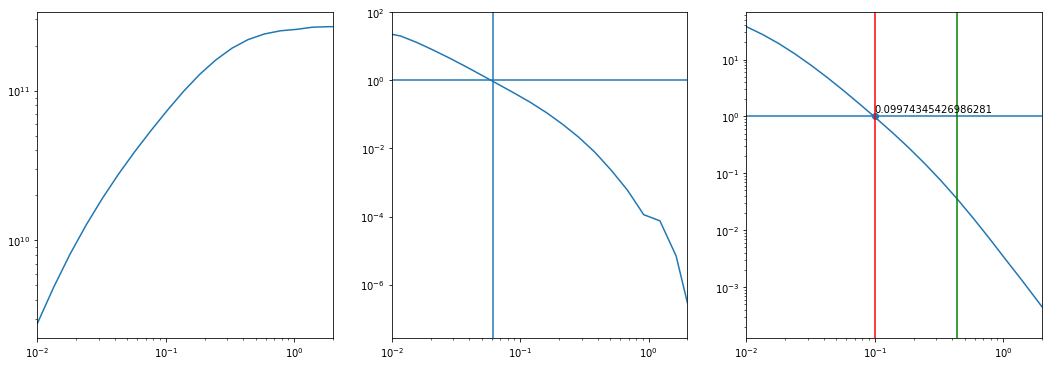

In [79]:
for j in range(len(radbins)-1):
    try:
        select_rad_ind = np.where(np.all((halvirrad>radbins[j], halvirrad<radbins[j+1], halprop.root.hostHaloID[:]==-1, abs(kin_ratio-1) < 0.5, ), axis=0))[0]
        select_rad_ind = select_rad_ind[np.where(radprof.root.Npart_profile[:][select_rad_ind].max(axis=1)<1000000)]
        print(radbins[j], radbins[j+1], len(select_rad_ind))
        mass_profile_mean = radprof.root.Mass_profile[:][select_rad_ind].mean(axis=0)
        r_vir_vr_mean = halprop.root.R_BN98[:][select_rad_ind].mean(axis=0)
        print(r_vir_vr_mean)
        fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(18,6), sharex=True)
        ax1.loglog(Rad_bin_edge[1:], np.cumsum(mass_profile_mean))
        ax1.set_xlim(1e-2,2)
        rhor = mass_profile_mean/ (4/3*np.pi* (Rad_bin_edge[1:]**3-Rad_bin_edge[:-1]**3) )/ vir_dens
        r_rho_is_vir = interp1d(rhor, Rad_bin_cen)(1)
        ax2.loglog(Rad_bin_cen, rhor,)
        ax2.axhline(1)
        ax2.axvline(r_rho_is_vir)
        rhoR = np.cumsum(mass_profile_mean)/ (4/3*np.pi* (Rad_bin_edge[1:]**3))/ vir_dens
        r_vir = interp1d(rhoR, Rad_bin_edge[1:])(1)
    #     idx_vir = np.argwhere(np.diff(np.sign(rhoR-1))).flatten()
        ax3.loglog(Rad_bin_edge[1:], rhoR ,)
        ax3.axhline(1)
        ax3.axvline(r_vir,color='red')
        ax3.axvline(r_vir_vr_mean, color='green')
        ax3.scatter(r_vir,1)
        ax3.annotate(f'{r_vir}', (r_vir,1.2))
    #     plt.ylim(0, 3)
        plt.show()
        sleep(.01)
        plt.close()
    except:
        print('noisy data')
        break
    

In [42]:
select_rad_ind.shape

(252577,)

In [44]:
np.median(radprof.root.Mass_profile[:][select_rad_ind], axis=0)

array([nan,  0., nan,  0., nan,  0., nan,  0., nan,  0., nan,  0., nan,
        0., nan,  0., nan,  0., nan,  0.], dtype=float32)

In [51]:
radprof.root.Mass_profile[:,1][select_rad_ind].max()

98811765000.0

In [69]:
prof1 = radprof.root.Npart_profile[:,1][select_rad_ind]
# prof1.sort()
np.percentile(prof1, 99.1)

34.0

In [75]:
np.where(radprof.root.Npart_profile[:][select_rad_ind].max(axis=1)<1000)

(array([     0,      1,      2, ..., 252574, 252575, 252576]),)

In [52]:
dir(radprof.root)

['File_id',
 'ID',
 'Inclusive_profiles_flag',
 'Mass_inclusive_profile',
 'Mass_profile',
 'Npart_inclusive_profile',
 'Npart_profile',
 'Num_of_bin_edges',
 'Num_of_files',
 'Num_of_groups',
 'Num_of_halos',
 'Radial_bin_edges',
 'Radial_norm',
 'Total_num_of_groups',
 'Total_num_of_halos',
 '_AttributeSet',
 '__class__',
 '__contains__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__members__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_c_classid',
 '_c_lazy_children_attrs',
 '_f_close',
 '_f_copy',
 '_f_copy_children',
 '_f_delattr',
 '_f_flush',
 '_f_get_child',
 '_f_getattr',
 '_f_isvisible',
 '_f_iter_nodes',
 '_f_list_nodes',
 '_f_move'

In [42]:
rad_phase = tables.open_file("/scratch/cprem/sims/bdm_cdm1024/r1/halo_centric/TSC/512/phase-space/phase-space_100_1by1_M_2.9e+12to3.1e+12_G_0.5to1.hdf5")

In [43]:
pos_r = rad_phase.root.radius[:]

In [44]:
mass_profile_mean = np.histogram(pos_r, Rad_bin_edge)[0]* 0.63*1e9/.15e3

In [45]:
h**2/a**3

2.945250978007029

In [46]:
mass_profile_mean

array([1.7148600e+10, 1.6308600e+10, 2.6497800e+10, 4.0219200e+10,
       5.7779400e+10, 8.0799600e+10, 1.0932600e+11, 1.4248500e+11,
       1.8096960e+11, 2.3117640e+11, 2.9252160e+11, 3.5337120e+11,
       3.9545940e+11, 4.0642560e+11, 4.1198220e+11, 4.8376020e+11,
       7.3193820e+11, 1.3249614e+12, 2.6967234e+12, 5.4194826e+12])

In [47]:
# r_vir_vr_mean = 

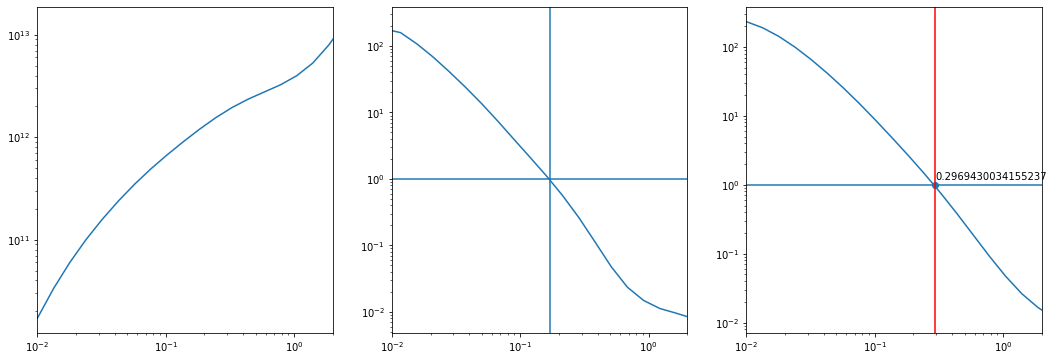

In [48]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(18,6), sharex=True)
ax1.loglog(Rad_bin_edge[1:], np.cumsum(mass_profile_mean))
ax1.set_xlim(1e-2,2)
rhor = mass_profile_mean/ (4/3*np.pi* (Rad_bin_edge[1:]**3-Rad_bin_edge[:-1]**3) )/ vir_dens
r_rho_is_vir = interp1d(rhor, Rad_bin_cen)(1)
ax2.loglog(Rad_bin_cen, rhor,)
ax2.axhline(1)
ax2.axvline(r_rho_is_vir)
rhoR = np.cumsum(mass_profile_mean)/ (4/3*np.pi* (Rad_bin_edge[1:]**3))/ vir_dens
r_vir = interp1d(rhoR, Rad_bin_edge[1:])(1)
#     idx_vir = np.argwhere(np.diff(np.sign(rhoR-1))).flatten()
ax3.loglog(Rad_bin_edge[1:], rhoR ,)
ax3.axhline(1)
ax3.axvline(r_vir,color='red')
# ax3.axvline(r_vir_vr_mean, color='green')
ax3.scatter(r_vir,1)
ax3.annotate(f'{r_vir}', (r_vir,1.2))
#     plt.ylim(0, 3)
plt.show()
sleep(.01)
plt.close()

In [115]:
r_vir_vr_mean

0.2021541205532228

In [ ]:
select_rad_ind = np.where(np.all((halvirrad>8e-2, halvirrad<5e-1, halprop.root.hostHaloID[:]==-1), axis=0))[0]
select_mass_ind = np.where(np.all((halvirmass>5e1, halvirmass<6e1, halprop.root.hostHaloID[:]==-1), axis=0))[0]
plt.plot(radprof.root.Radial_bin_edges[1:], radprof.root.Mass_profile[:][select_mass_ind][0:10].mean(axis=0))

In [ ]:
radprof.root.Mass_profile[:][select_mass_ind]

In [ ]:
plt.hist(halprop.root.Rvir, bins=np.logspace(-2,0))
plt.xscale('log')

In [ ]:
# halprop.root

In [ ]:
# pd.read_hdf(f"/scratch/cprem/sims/bdm_cdm1024/r1/halos_vr_6d/out_{i:03d}.profiles.0",'Mass_profile')

In [ ]:
radprof.close()
halprop.close()

In [28]:
def Omega(z, Om0):
    E = Om0 * (1+z)**3 + (1-Om0)
    return Om0 * (1+z)**3 / E

In [29]:
Omega(z=1.2,Om0=0.3)

0.8202547247329499

In [30]:
0.8202547247329499*200

164.05094494659

In [31]:
rad_bin_edge_input = np.array([-2.,-1.87379263,-1.74758526,-1.62137789,-1.49517052,-1.36896316,-1.24275579,-1.11654842,-0.99034105,-0.86413368,-0.73792631,-0.61171894,-0.48551157,-0.3593042,-0.23309684,-0.10688947,0.0193179,0.14552527,0.27173264,0.39794001,
])

In [33]:
radprof.root.Radial_bin_edges[:]

array([0.        , 0.01      , 0.01337234, 0.01788194, 0.02391234,
       0.0319764 , 0.04275992, 0.05718001, 0.07646304, 0.10224897,
       0.1367308 , 0.18284105, 0.24450123, 0.32695534, 0.43721576,
       0.5846597 , 0.78182676, 1.04548523, 1.39805828, 1.86953082,
       2.50000001])

In [35]:
10**rad_bin_edge_input

array([0.01      , 0.01337234, 0.01788194, 0.02391234, 0.03197639,
       0.04275992, 0.05718001, 0.07646304, 0.10224897, 0.13673079,
       0.18284104, 0.24450124, 0.32695534, 0.43721575, 0.5846597 ,
       0.78182676, 1.04548523, 1.39805826, 1.86953087, 2.50000001])

In [36]:
rad_bin_edge_input[1:]-rad_bin_edge_input[:-1]

array([0.12620737, 0.12620737, 0.12620737, 0.12620737, 0.12620736,
       0.12620737, 0.12620737, 0.12620737, 0.12620737, 0.12620737,
       0.12620737, 0.12620737, 0.12620737, 0.12620736, 0.12620737,
       0.12620737, 0.12620737, 0.12620737, 0.12620737])

In [38]:
radprof.root.Mass_profile[:][select_mass_ind][0:10].mean(axis=0).sum()

56.08415

In [41]:
for j in range(len(massbins)-1):
    select_mass_ind = np.where(np.logical_and(halvirmass>massbins[j], halvirmass<massbins[j+1], halprop.root.hostHaloID[:]==-1))[0]
    print(radprof.root.Mass_profile[:][select_mass_ind][0:10].mean(axis=0).sum())

15.668254
22.036436
34.835854
53.120735
83.196236
148.58047
217.74777
350.25037
576.16315
788.6141
1280.5109
1490.1583
1139.1132
550.5258
722.24243


In [44]:
halprop.root.Xc[:].max()

149.99952083191604

In [45]:
halprop.close()